In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
        Info Given PhasorNetworks was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? PhasorNetworks
[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage = -0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [8]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [9]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test ODE Layer

In [10]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [11]:
ps_phase2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
            layer_2 = ())

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = ())

In [12]:
p0, _ = to_phase(x, ps_phase2, st_phase)

([0.9621183521796359 0.14853194706872877 … 0.17156837979634934 0.2207192722515445; -0.7507570041684075 0.867429651787117 … -0.4410375489659723 -0.15208475266136406], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

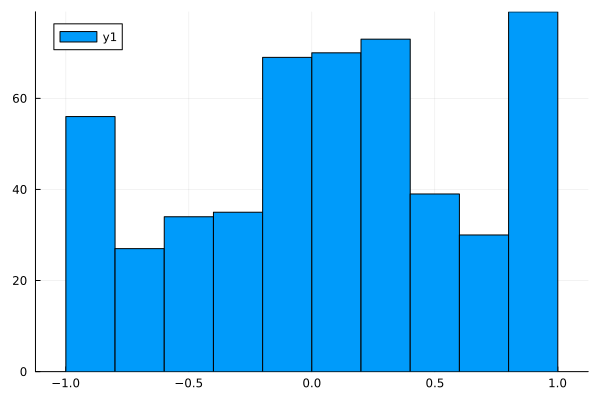

In [13]:
histogram(vec(p0))

In [14]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [15]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [16]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [17]:
using ChainRulesCore: ignore_derivatives

In [18]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, mod(t, spk_args.t_period), spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [19]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#26"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

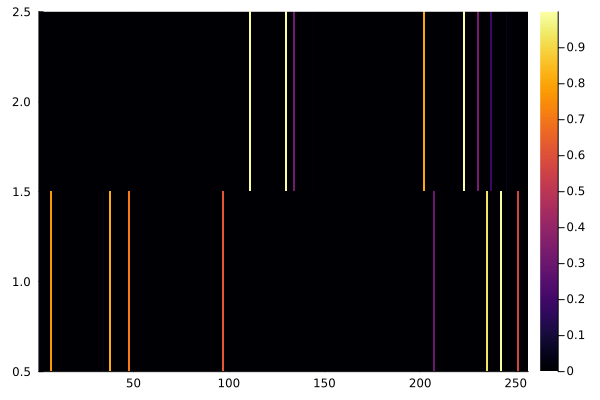

In [20]:
heatmap(xfn(1.4))

In [21]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [22]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt], dense=true))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#29),
    layer_3 = WrappedFunction(#30),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [23]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [24]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#149"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#26"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(

In [35]:
p_sol = potential_to_phase(Array(y_sol), y_sol.t, offset=0.0, spk_args=spk_args);

In [29]:
mp = mean_phase(y_sol, 1, spk_args=spk_args, offset=0.0)

128×256 Matrix{Float64}:
 -0.980866    0.693825    -0.724934   …   0.919728     0.663018   0.852146
  0.578705   -0.174979    -0.517169      -0.184476    -0.865661  -0.188023
  0.477004   -0.225057    -0.433095      -0.146093    -0.747079  -0.172542
 -0.866185    0.713372    -0.818524       0.903334     0.569487   0.846141
 -0.400302    0.844859     0.470052       0.80066      0.10861    0.805646
  0.794376    0.577086    -0.621136   …  -0.970481     0.875217   0.891853
  0.465534   -0.228464    -0.420016      -0.14343     -0.734513  -0.171505
 -0.0333692  -0.317939     0.303803      -0.0701997   -0.292587  -0.144193
  0.432376   -0.237106    -0.376118      -0.136641    -0.699177  -0.168881
  0.667666   -0.00894057  -0.565778      -0.312333    -0.975553  -0.253577
  0.389788   -0.24633     -0.305337   …  -0.12934     -0.655884  -0.166086
  0.480089   -0.224096    -0.436447      -0.146843    -0.75049   -0.172834
  0.276679   -0.26555     -0.0609358     -0.113925    -0.550583  -0.160267


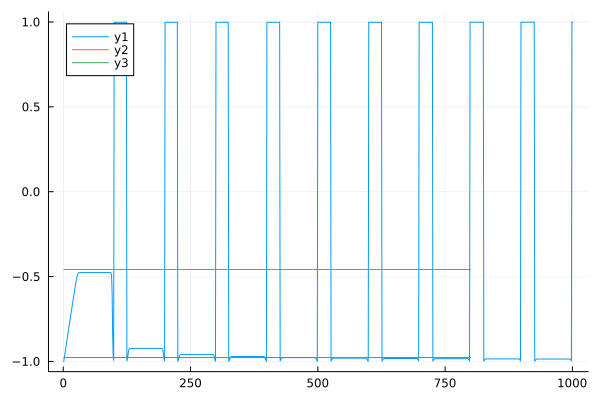

In [30]:
plot(p_sol[1,1,:])
plot!(mean(p_sol[1,1,201:end]) .* ones(1001-201))
plot!(median(p_sol[1,1,201:end]) .* ones(1001-201))
plot!(mp[1,1] .* ones(1001 - 201))

In [31]:
mp[1,1]

-0.9808659735520587

In [32]:
mean(mean_phase(sol_model(x, ps_sol, st_sol)[1], 1, offset=0.0, spk_args=spk_args))

0.0012993277165353383

In [33]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))

In [34]:
withgradient(p -> mean(mean_phase(sol_model(x, p, st_sol)[1], 1, offset=0.0, spk_args=spk_args)), psf_sol)

(val = 0.0012993277749260446, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.00041682454 -0.0014570102; -3.2402808f-5 0.00015625183; … ; 3.68778f-5 1.9236133f-5; -3.830477f-5 -3.9053186f-5], bias = Float32[0.020129725; -0.0064334366; … ; 0.0045710467; -0.004003318;;])),))

In [73]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128, relu)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0),
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#80),
    layer_3 = WrappedFunction(#81),
    layer_4 = PhasorODE(
        model = Dense(2 => 128, relu),  # 384 parameters
    ),
    layer_5 = WrappedFunction(#82),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [74]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [75]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.1388895857349044 -0.24762946681285428 … -0.09585463182428762 -0.022814990612870314; -0.12145233625080384 -0.3642379516288792 … -0.2215795230288057 -0.10676102606202675], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [76]:
y_ode

2×256 Matrix{Float64}:
 -0.13889   -0.247629  0.302192  …   0.021912   -0.0958546  -0.022815
 -0.121452  -0.364238  0.348769     -0.0415768  -0.22158    -0.106761

In [77]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.12618394 -0.14341271; 0.0061234655 -0.11382582; … ; 0.115465544 0.025707481; -0.14921375 0.058093682], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.7864307 -0.22364718 … -1.0674167 -0.07923391; -0.34585118 -0.5941257 … -0.78755206 0.66918004], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [78]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

0.8730731967057322

In [79]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

In [ ]:
ps_ode2 = (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]),
        layer_2 = ps_ode.layer_2,
        layer_3 = ps_ode.layer_3,
        layer_4 = ps_ode.layer_4,
        layer_5 = ps_ode.layer_5,
        layer_6 = ps_ode.layer_6)

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.11354149 -0.008581205; 0.0064453864 -0.20159426; … ; -0.15014033 -0.057043303; 0.019505545 0.06635483], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.7454502 -0.7357894 … -0.2531807 -0.97788376; 0.28430146 -0.2689025 … 0.92974263 0.2551111], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [ ]:
psf = ComponentArray(ps_ode2)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.11354149 -0.008581205; 0.0064453864 -0.20159426; … ; -0.15014033 -0.057043303; 0.019505545 0.06635483], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.7454502 -0.7357894 … -0.2531807 -0.97788376; 0.28430146 -0.2689025 … 0.92974263 0.2551111], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [ ]:
args.epochs = 5

5

In [ ]:
losses, ps_train, st_train = train(ode_model, psf, st_ode, train_loader, args, verbose=true)

[ Info: Training on CPU


Epoch 1 loss: 0.8550379495074386
Epoch 1 loss: 0.7543720835674912
Epoch 1 loss: 0.6600137733839573
Epoch 1 loss: 0.7253521004171988
Epoch 1 loss: 0.710748988476548
Epoch 1 loss: 0.7498941907765112
Epoch 1 loss: 0.7592907805699607
Epoch 1 loss: 0.8332370808593614
Epoch 1 loss: 0.6804012616838284
Epoch 1 loss: 0.7845955884399101
Epoch 1 loss: 0.6253845633414432
Epoch 1 loss: 0.6776547680847229
Epoch 1 loss: 0.6578971184241311
Epoch 1 loss: 0.6962604575959918
Epoch 1 loss: 0.6814489891061944
Epoch 1 loss: 0.6953660101865058
Epoch 1 loss: 0.6919109593429088
Epoch 1 loss: 0.6264703162392078
Epoch 1 loss: 0.5985532736508914
Epoch 1 loss: 0.5996450997382258
Epoch 1 loss: 0.6562443555220095
Epoch 1 loss: 0.6648452477519875
Epoch 1 loss: 0.6191425677855629
Epoch 1 loss: 0.5601303664094449
Epoch 1 loss: 0.6029688680157841
Epoch 1 loss: 0.5046692026664056
Epoch 1 loss: 0.5430977234268581
Epoch 1 loss: 0.5024473549964569
Epoch 1 loss: 0.4752656432018324
Epoch 1 loss: 0.5528459015627645
Epoch 1 los

(Any[0.8550379495074386, 0.7543720835674912, 0.6600137733839573, 0.7253521004171988, 0.710748988476548, 0.7498941907765112, 0.7592907805699607, 0.8332370808593614, 0.6804012616838284, 0.7845955884399101  …  0.2184828208227882, 0.23343600128750494, 0.23588233032699663, 0.24077048598999098, 0.2345239821595954, 0.21537253548258323, 0.23403670243637545, 0.21204356180802297, 0.23524248271124779, 0.21968725571811817], (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.09488324 0.028293515; -0.029670171 -0.17581382; … ; -0.1585604 -0.04954736; -0.0033525238 0.07328256], bias = Float32[-0.00618323; 0.0025278411; … ; 0.0063496213; -0.01932562;;]), layer_5 = Float32[], layer_6 = (weight = Float32[0.7448137 -0.7596616 … -0.25705394 -0.94535494; 0.28541365 -0.267844 … 0.92221886 0.25645345], bias_real = Float32[1.0627688, 1.0603982], bias_imag = Float32[0.028155943, 0.011405706])),

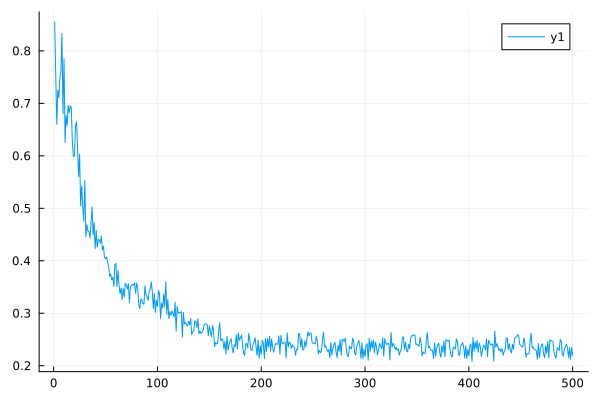

In [ ]:
plot(losses)

In [ ]:
ps_train .- psf

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.01865825 0.03687472; -0.036115557 0.02578044; … ; -0.008420065 0.0074959435; -0.022858068 0.0069277287], bias = Float32[-0.00618323; 0.0025278411; … ; 0.0063496213; -0.01932562;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.000636518 -0.023872197 … -0.003873229 0.032528818; 0.0011121929 0.0010585189 … -0.007523775 0.0013423562], bias_real = Float32[0.06276882, 0.06039822], bias_imag = Float32[0.028155943, 0.011405706]))

In [ ]:
loss_and_accuracy(test_loader, ode_model, ps_train, st_train)

(0.22886061723188894, 0.705859375)

In [ ]:
loss_and_accuracy(test_loader, ode_model, ps_train, st_train)

(0.22886061723188894, 0.705859375)